In [1]:
#ignore warnings
import warnings
warnings.filterwarnings("ignore")

#linear algebra
import numpy as np
import pandas as pd
import sys
#import lux
 

#statistical tests
from scipy import stats
from scipy.stats import pearsonr, spearmanr


from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import median_absolute_error, r2_score, mean_absolute_error, mean_squared_error
from statsmodels.formula.api import ols

#visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import plotly.express as px
import bamboolib as bam
import plotly.graph_objs as go
import plotly.io as pio

pio.renderers

#display max columns
pd.set_option('display.max_columns', None)
#use this format specifier exactly AS IS to avoid breaking module, space matters!
pd.options.display.float_format = '{:20,.2f}'.format 
sns.set_style("white")

In [2]:
# the system path
sys.path.append('/Users/Ray/codeup-data-science/fifa')
 
# importing the function
from acquire import get_fifa_data

In [3]:
import sys
 
# the system path
sys.path.append('/Users/Ray/codeup-data-science/fifa')
 
# importing split
import prepare, model

In [4]:
#acquire
df = get_fifa_data()

In [5]:
#prepare
df = prepare.prepped_data(df)

Before dropping nulls, 142079 rows, 111 cols
After dropping nulls. 131489 rows. 66 cols
After cleaning the data and adding additional columns there are: 98804 rows. 83 cols


In [6]:
#return defenders df after prepped
goalkeeper_df, forward_df, midfielder_df, defender_df = prepare.acquire_players_by_position(df)

In [7]:
# 1) Does age impact salary?
# 2) Does seniority(length of time playing with a club) impact salary?
# 3) Does the league a player is with impact salary?
# 4) Do players with unusual body types have higher or lower salaries?
# 5) Does nationality impact salary?
# 6) Does international reputation impact salary?
# 7) Does contract length positively or negatively impact salary? (edited) 

In [8]:
#split data on defenders
train, validate, test = prepare.split(defender_df)
# Step: Keep rows where (age is not missing) and (wage_eur is not missing)
train = train.loc[(train['age'].notna()) & (train['wage_eur'].notna())]

# Step: Sort column(s) age ascending (A-Z), wage_eur ascending (A-Z)
train = train.sort_values(by=['age', 'wage_eur'], ascending=[True, True])

# Step: Group by and aggregate
train_nation = train.groupby(['nationality_name']).agg(wage_eur_sum=('wage_eur', 'sum')).reset_index()

# Step: Sort column(s) wage_eur_sum descending (Z-A)
train_nation = train_nation.sort_values(by=['wage_eur_sum'], ascending=[False])

# Step: Change data type of wage_eur_sum to Integer
train_nation['wage_eur_sum'] = pd.to_numeric(train_nation['wage_eur_sum'], downcast='integer', errors='coerce')

train_nation

Train: 19072 rows, 83 cols
Validate: 8542 rows, 83 cols
Test: 4647 rows, 83 cols


     nationality_name  wage_eur_sum
123             Spain      24575000
16             Brazil      24407500
48             France      18979500
4           Argentina      17591000
42            England      15387500
..                ...           ...
32               Cuba          2000
95          Nicaragua          1000
102  Papua New Guinea          1000
2             Andorra          1000
124             Sudan           500

[145 rows x 2 columns]

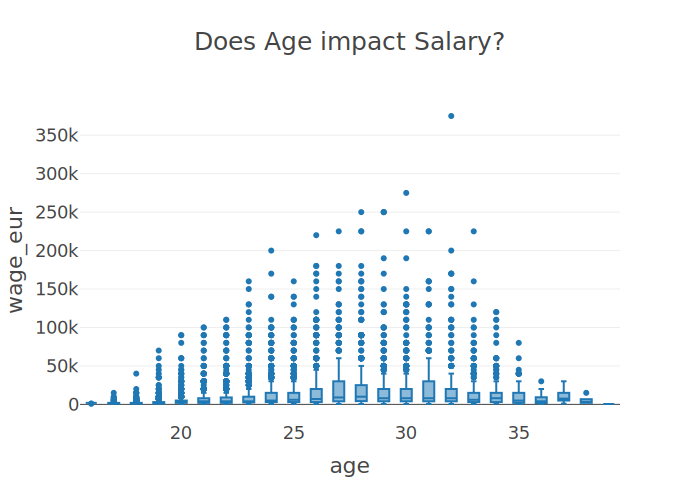

In [9]:
# graphs age vs salary on boxplot
fig = px.box(train.sample(n=10000, replace=False, random_state=123).sort_index(), x='age', y='wage_eur', 
             hover_name='wage_eur', template='presentation', title='Does Age impact Salary?')
fig.show(renderer="svg")

### Takeaway

In [10]:
top_15 = df.nlargest(15, 'overall')
top_15.head(5)

       sofifa_id         short_name player_positions  overall  potential  \
13956     158023           L. Messi       RW, CF, ST       94         94   
13989     158023           L. Messi       CF, RW, ST       94         94   
14076     158023           L. Messi           RW, CF       94         95   
14260      20801  Cristiano Ronaldo           LW, ST       94         94   
14286      20801  Cristiano Ronaldo       LW, LM, ST       94         94   

                 value_eur             wage_eur  age  height_cm  weight_kg  \
13956        95,500,000.00           560,000.00   32        170         72   
13989       110,500,000.00           575,000.00   31        170         72   
14076       111,000,000.00           550,000.00   28        170         72   
14260        95,500,000.00           575,000.00   32        185         80   
14286        87,000,000.00           575,000.00   31        185         80   

              club_team_id       club_name             league_name  \
1395

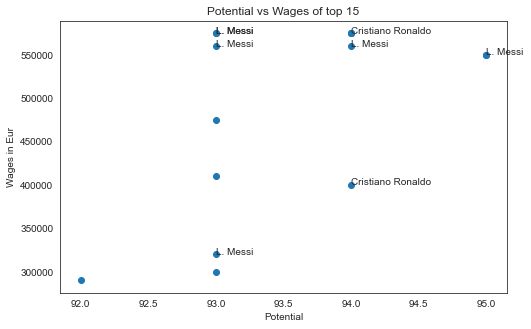

In [11]:
# Let's see if high overall score correlates with earnings, for the top 15 players

fig, ax = plt.subplots(figsize=(8,5))

plt.scatter(top_15['potential'], top_15['wage_eur'] )
plt.text(top_15.iloc[0]['potential'], top_15.iloc[0]['wage_eur'], top_15.iloc[0]['short_name'])
# plt.text(top_15.iloc[1]['potential'], top_15.iloc[1]['wage_eur'], top_15.iloc[1]['short_name']) for better view
plt.text(top_15.iloc[2]['potential'], top_15.iloc[2]['wage_eur'], top_15.iloc[2]['short_name'])
# plt.text(top_15.iloc[3]['potential'], top_15.iloc[3]['wage_eur'], top_15.iloc[3]['short_name'])
plt.text(top_15.iloc[4]['potential'], top_15.iloc[4]['wage_eur'], top_15.iloc[4]['short_name'])
plt.text(top_15.iloc[5]['potential'], top_15.iloc[5]['wage_eur'], top_15.iloc[5]['short_name'])
plt.text(top_15.iloc[6]['potential'], top_15.iloc[6]['wage_eur'], top_15.iloc[6]['short_name'])
plt.text(top_15.iloc[7]['potential'], top_15.iloc[7]['wage_eur'], top_15.iloc[7]['short_name'])
plt.text(top_15.iloc[8]['potential'], top_15.iloc[8]['wage_eur'], top_15.iloc[8]['short_name'])
plt.text(top_15.iloc[9]['potential'], top_15.iloc[9]['wage_eur'], top_15.iloc[9]['short_name'])

ax.set_title("Potential vs Wages of top 15")
ax.set_ylabel('Wages in Eur')
ax.set_xlabel('Potential')

plt.show()

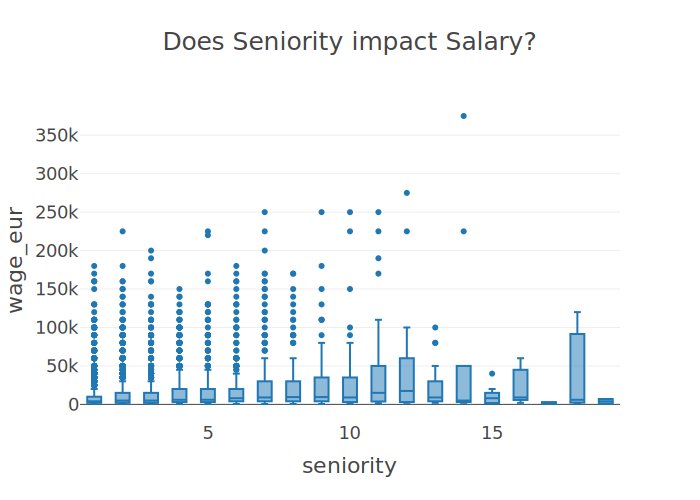

In [12]:

fig = px.box(train.sample(n=10000, replace=False, random_state=123).sort_index(), x='seniority', y='wage_eur', 
             template='presentation', title='Does Seniority impact Salary?')
fig.show(renderer="svg")

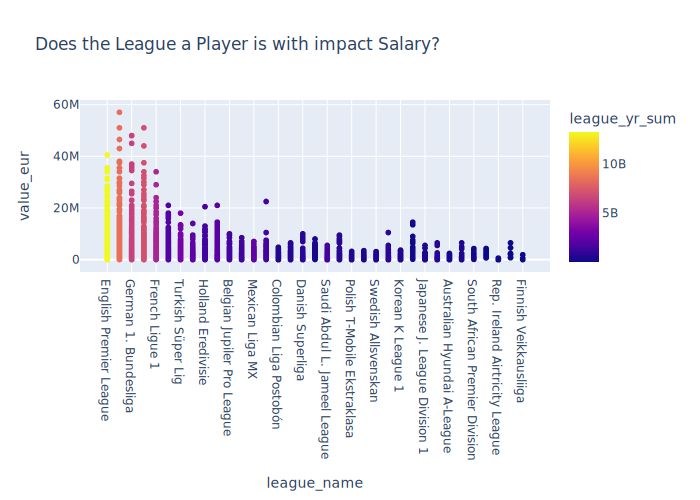

In [13]:

fig = px.scatter(train.sample(n=10000, replace=False, random_state=123).sort_index(), x='league_name', y='value_eur', color='league_yr_sum', title='Does the League a Player is with impact Salary?')
fig.update_xaxes(categoryorder='total descending')
fig.show(renderer='svg')

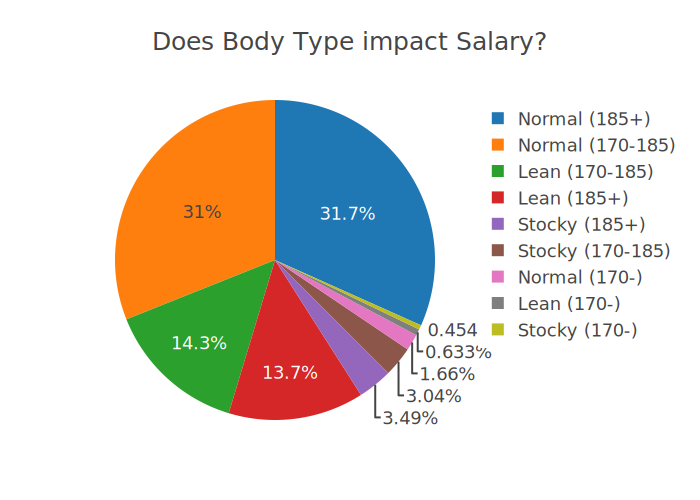

In [14]:
import plotly.express as px
fig = px.pie(train.sample(n=10000, replace=False, random_state=123).sort_index(), values='total_wage', names='body_type', template='presentation', title='Does Body Type impact Salary?')
fig.show(renderer="svg")

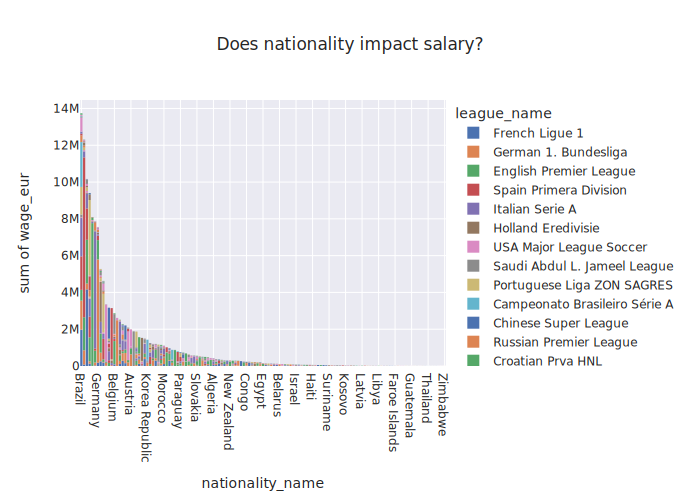

In [15]:

fig = px.histogram(train.sample(n=10000, replace=False, random_state=123).sort_index(), x='nationality_name', y='wage_eur', template='seaborn', color='league_name', title='Does nationality impact salary?')
fig.update_xaxes(categoryorder='total descending')
fig.update_layout(autosize=True)
fig.show(renderer="svg")

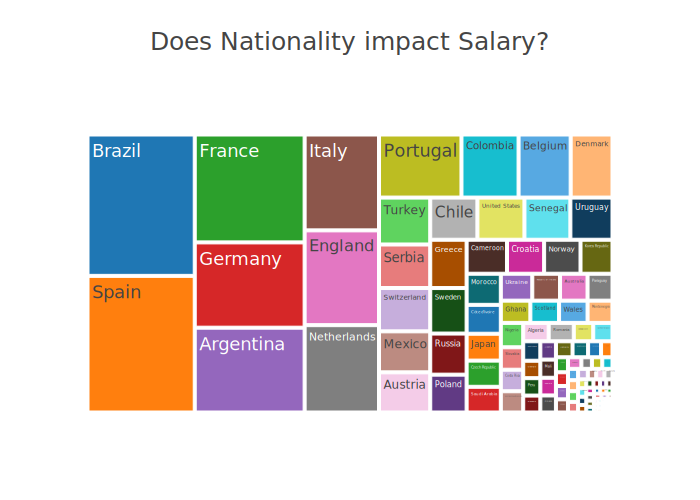

In [16]:

fig = px.treemap(train.sample(n=10000, replace=False, random_state=123).sort_index(), path=['nationality_name'], values='total_wage', title='Does Nationality impact Salary?', template='presentation')
fig.show(renderer='svg')

Text(0.5, 1.0, 'Does international reputation impact salary?')

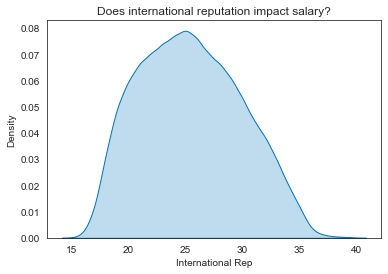

In [17]:
Mth = sns.kdeplot(train.age[(train["total_wage"] >1) ],
                color="#0072BD", shade = True)
Mth.set_ylabel('Density')
Mth.set_xlabel('International Rep')
Mth.set_title('Does international reputation impact salary?')


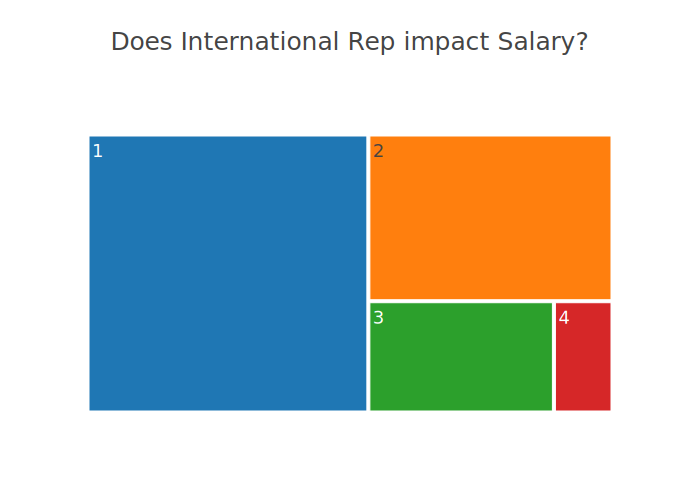

In [18]:
import plotly.express as px
fig = px.treemap(train.sample(n=10000, replace=False, random_state=123).sort_index(), path=['international_reputation'], values='total_wage', title='Does International Rep impact Salary?', template='presentation')
fig.show(renderer='svg')

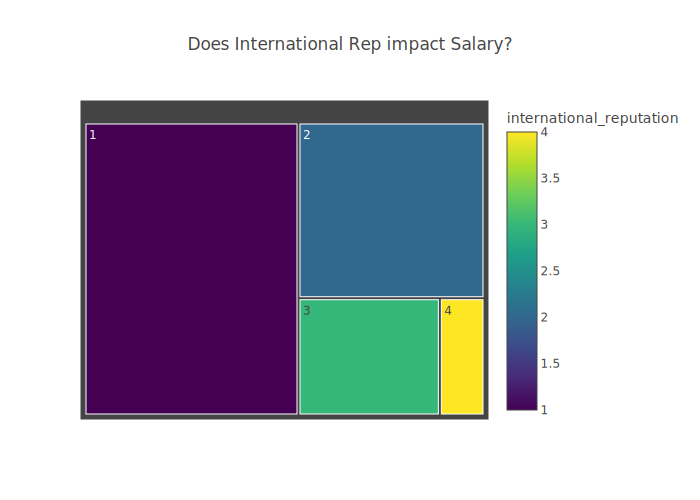

In [19]:
import plotly.express as px
fig = px.treemap(train.sample(n=10000, replace=False, random_state=123).sort_index(), path=['international_reputation'], values='total_wage', title='Does International Rep impact Salary?', template='xgridoff', color='international_reputation')
fig.show(renderer='svg')

<AxesSubplot:xlabel='international_reputation', ylabel='total_wage'>

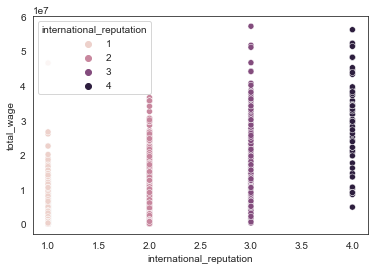

In [20]:
# Plots lats/longs by tax amount
sns.scatterplot(x=train.international_reputation , y=train.total_wage, hue=train.international_reputation)

<AxesSubplot:xlabel='international_reputation', ylabel='total_wage'>

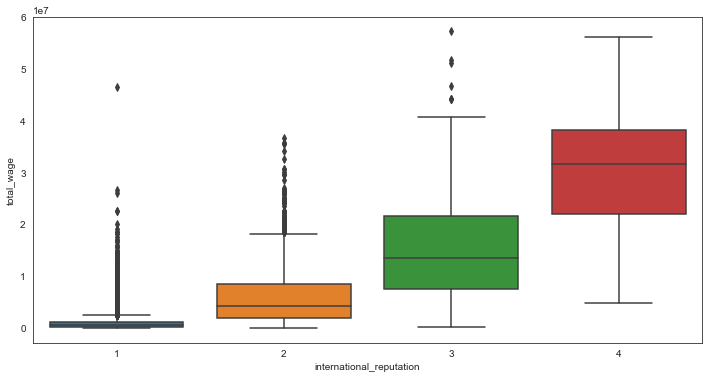

In [21]:
# boxplot showing total wage by international rep
plt.figure(figsize=(12,6))
sns.boxplot(x= train[train.total_wage>1].international_reputation, 
            y= train[train.total_wage>1].total_wage, data=train[train.total_wage>1])

In [22]:
#categorical columns
catcols = [col for col in train.columns if train[col].dtype == 'O']
catcols

['short_name',
 'player_positions',
 'club_name',
 'league_name',
 'nationality_name',
 'club_position',
 'position',
 'field_position',
 'club_joined',
 'body_type',
 'preferred_foot',
 'work_rate']

In [23]:
#numerical columns
numcols = [col for col in train.columns if train[col].dtype !='O']
numcols

['sofifa_id',
 'overall',
 'potential',
 'value_eur',
 'wage_eur',
 'age',
 'height_cm',
 'weight_kg',
 'club_team_id',
 'nationality_id',
 'club_contract_valid_until',
 'weak_foot',
 'skill_moves',
 'international_reputation',
 'pace',
 'shooting',
 'passing',
 'dribbling',
 'defending',
 'physical',
 'crossing',
 'finishing',
 'heading_accuracy',
 'short_passing',
 'volleys',
 'skill_dribbling',
 'curve',
 'fk_accuracy',
 'long_passing',
 'ball_control',
 'acceleration',
 'sprint_speed',
 'agility',
 'reactions',
 'balance',
 'shot_power',
 'jumping',
 'stamina',
 'strength',
 'long_shots',
 'aggression',
 'interceptions',
 'positioning',
 'vision',
 'penalties',
 'marking',
 'standing_tackle',
 'sliding_tackle',
 'gk_diving',
 'gk_handling',
 'gk_kicking',
 'gk_positioning',
 'gk_reflexes',
 'gk_speed',
 'year',
 'total_wage',
 'age_bins',
 'height_bins',
 'weight_bins',
 'year_joined',
 'wage_year',
 'league_yr_sum',
 'club_name_yr_sum',
 'seniority',
 'club_position_encoded',
 'wo

In [24]:
#return unique numerical values
unique_values = df.select_dtypes(include='number').nunique().sort_values()

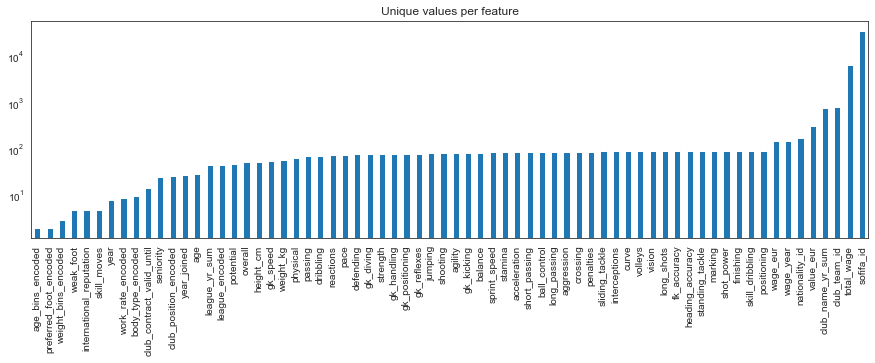

In [25]:
# Plot information with y-axis in log-scale
unique_values.plot.bar(logy=True, figsize=(15, 4),
                       title="Unique values per feature");

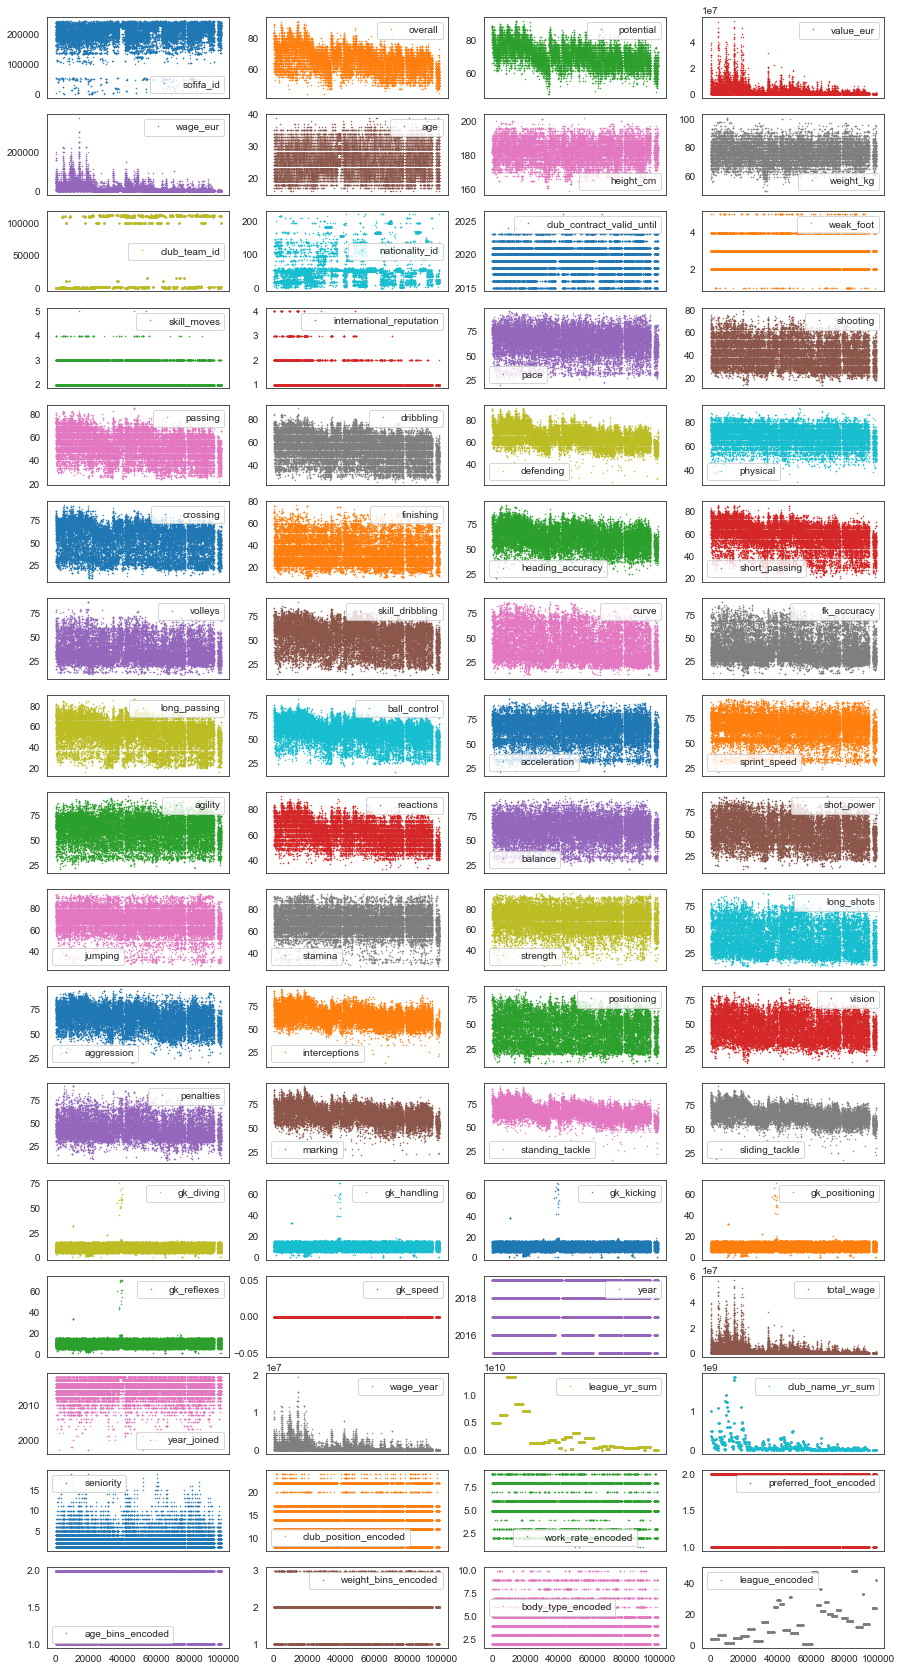

In [26]:
#plots all numerical values
#lw=0: lw stands for line width. 0 means that we don't want to show any lines
#marker=".": Instead of lines, we tell the plot to use . as markers for each data point
#subplots=True: subplots tells pandas to plot each feature in a separate subplot
#layout=(-1, 4): This parameter tells pandas how many rows and columns to use for the subplots. 
#The -1 means "as many as needed", while the 2 means to use 2 columns per row.
#figsize=(15, 30), markersize=1: To make sure that the figure is big enough we recommend to have a 
#figure height of roughly the number of features, and to adjust the markersize accordingly.

train.plot(lw=0, marker='.',subplots=True,layout=(-1,4),figsize=(15,30),markersize=1);

In [27]:
# General look at how many unique values each of these non-numerical features contain, and how often their most
# frequent category is represented.
train.describe(exclude=['number','datetime'])

       short_name player_positions    club_name                 league_name  \
count       19072            19072        19072                       19072   
unique       8539              308          651                          35   
top       Marcelo               CB  FC Augsburg  Argentina Primera División   
freq           16             8702           62                        1081   

       nationality_name club_position    position field_position club_joined  \
count             19072         19072       19072          19072       19072   
unique              145             9           9              3        1705   
top           Argentina           SUB  Substitute       Defender  2015-07-01   
freq               1271          7516        7516           8589         619   

               body_type preferred_foot      work_rate age_bins height_bins  \
count              19072          19072          19072    19072       19072   
unique                 9              2      

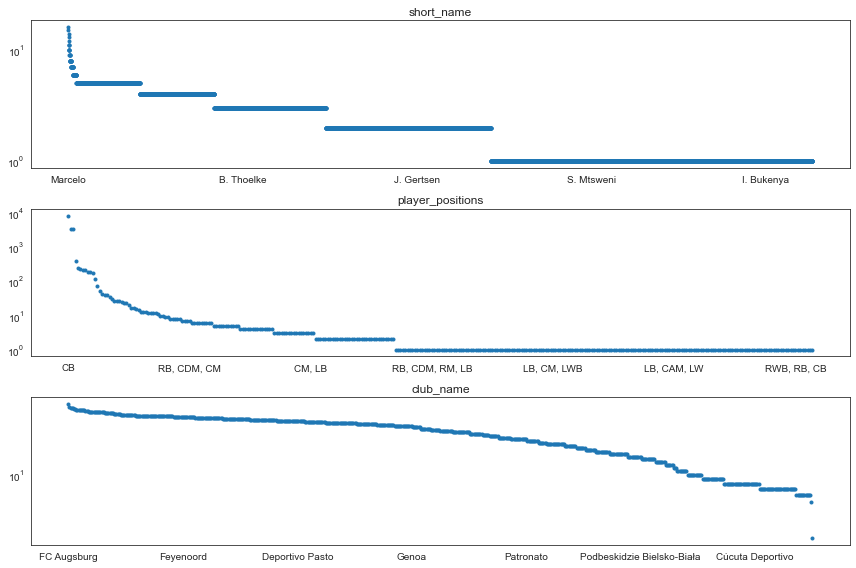

In [28]:
# Create figure object with 3 subplots
fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(12, 8))

# Identify non-numerical features
df_non_numerical = train.select_dtypes(exclude=["number", "datetime"])

# Loop through features and put each subplot on a matplotlib axis object
for col, ax in zip(df_non_numerical.columns, axes.ravel()):

    # Selects one single feature and counts number of unique value
    df_non_numerical[col].value_counts().plot(

        # Plots this information in a figure with log-scaled y-axis
        logy=True, title=col, lw=0, marker=".", ax=ax)
    
plt.tight_layout();

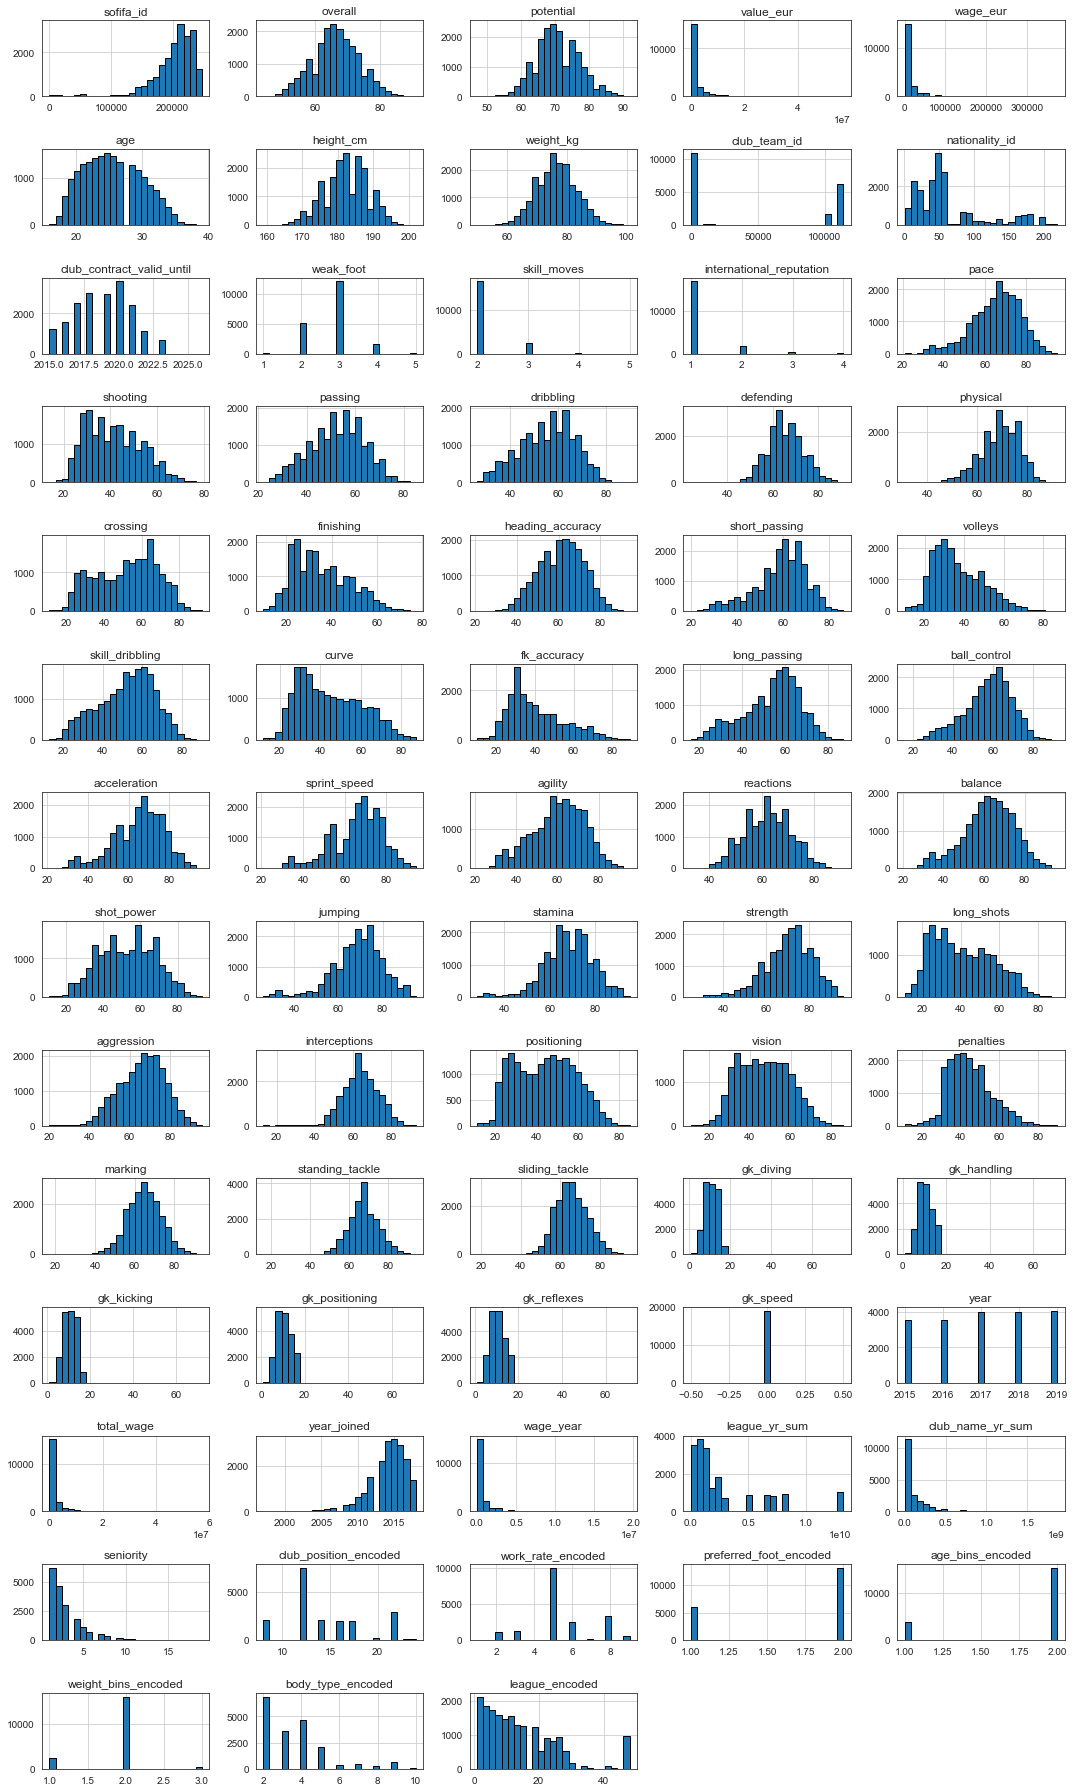

In [29]:
# Plots the histogram for each numerical feature in a separate subplot
train.hist(bins=25, figsize=(15, 25), layout=(-1, 5), edgecolor="black")
plt.tight_layout();

# Feature patterns
Next step on the list is the investigation of feature specific patterns. The goal of this part is two fold:

> 1. Can we identify particular patterns within a feature that will help us to decide if some entries need to be dropped or modified?
> 2. Can we identify particular relationships between features that will help us to better understand our dataset?
> - randomly selected features

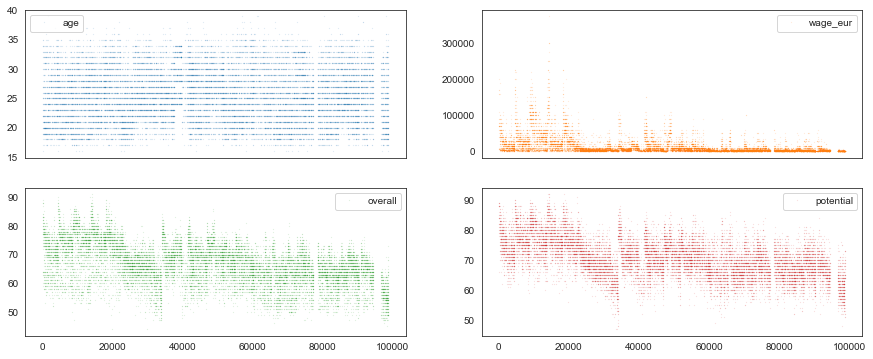

In [30]:
train[["age",
      "wage_eur",
      'overall',
      'potential']].plot(
    lw=0, marker=".", subplots=True, layout=(-1, 2),
  markersize=0.1, figsize=(15, 6));

In [31]:
# Creates mask to identify numerical features with at least 25 unique features
cols_continuous = train.select_dtypes(include="number").nunique() >= 25

In [32]:
# Create a new dataframe which only contains the continuous features
df_continuous = train[cols_continuous[cols_continuous].index]
df_continuous.shape

(19072, 53)

In [33]:
#takes too long to run.

#sns.pairplot(df_continuous, height=1.5,
             #plot_kws={"s": 2, "alpha": 0.2});

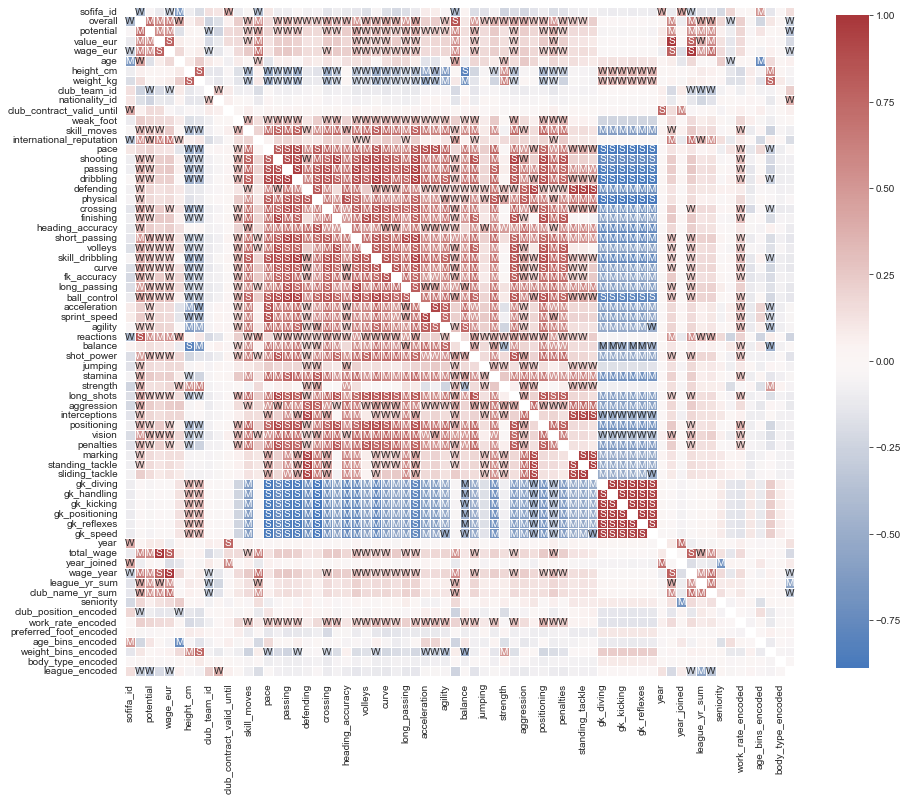

In [34]:
# Computes feature correlation
df_corr = df.corr(method="pearson")

# Create labels for the correlation matrix
labels = np.where(np.abs(df_corr)>0.75, "S",
                  np.where(np.abs(df_corr)>0.5, "M",
                           np.where(np.abs(df_corr)>0.25, "W", "")))

# Plot correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(df_corr, mask=np.eye(len(df_corr)), square=True,
            center=0, annot=labels, fmt='', linewidths=.5,
            cmap="vlag", cbar_kws={"shrink": 0.8});

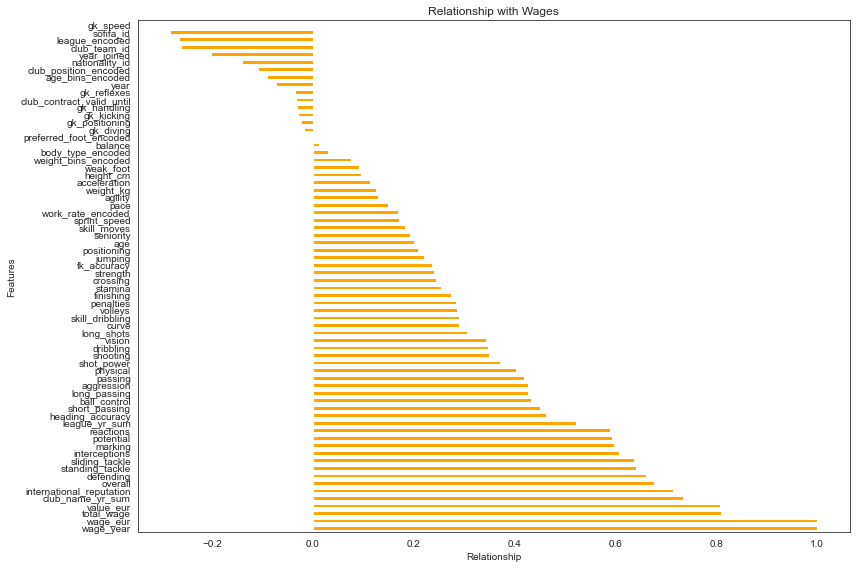

In [35]:
plt.figure(figsize = (12 , 8))
train.corr()['wage_eur'].sort_values(ascending = False).plot(kind = 'barh', color = 'orange')
#plt.figure(figsize= 3,3)
plt.title('Relationship with Wages')
plt.xlabel('Relationship')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# - 1.) Does age impact salary?

Pearson's Correlation Coefficient

$\alpha$ = .05

$𝐻_{0}$: There is no linear correlation with between age and salary.

𝐻𝑎: There is a linear relationship between age and salary.

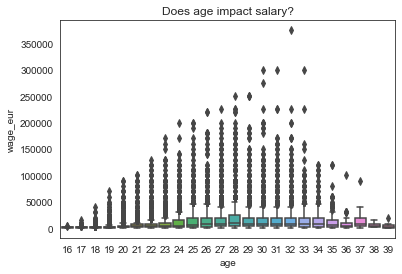

In [36]:
#rays visualization
sns.boxplot(train.age, train.wage_eur)
plt.title("Does age impact salary?")
rcParams['figure.figsize'] = 12, 5
plt.show()

In [37]:
import pandas as pd
df = pd.read_csv(r'/Users/Ray/codeup-data-science/fifa/Ray/fifa.csv', sep=',', decimal='.', nrows=100000)
df

       sofifa_id                                         player_url  \
0         158023  https://sofifa.com/player/158023/lionel-messi/...   
1         188545  https://sofifa.com/player/188545/robert-lewand...   
2          20801  https://sofifa.com/player/20801/c-ronaldo-dos-...   
3         190871  https://sofifa.com/player/190871/neymar-da-sil...   
4         192985  https://sofifa.com/player/192985/kevin-de-bruy...   
...          ...                                                ...   
99995     226592  https://sofifa.com/player/226592/jakub-jankto/...   
99996     226615  https://sofifa.com/player/226615/franco-caneve...   
99997     226711  https://sofifa.com/player/226711/nik-omladic/1...   
99998     226723  https://sofifa.com/player/226723/leonardo-sald...   
99999     226733  https://sofifa.com/player/226733/david-ramirez...   

              short_name                            long_name  \
0               L. Messi       Lionel Andrés Messi Cuccittini   
1         R. Lewa

In [38]:
#set alpha
α = 0.05

#perform test
r, p = pearsonr(train.age, train.wage_eur)

#evaluate coefficient and p-value
print(f'Correlation Coefficient: {r:.3f}\nP-value: {p:.3f}')

#evaluate if p < α
if p < α:
    print('Reject the null hypothesis.')
else:
    print('Fail to reject the null hypothesis.')

Correlation Coefficient: 0.200
P-value: 0.000
Reject the null hypothesis.


# 2) Does seniority(length of time playing with a club) impact salary?

Spearman's Correlation Coefficient

$\alpha$ = .05

$𝐻_{0}$: There is no linear correlation with between seniority and salary.

𝐻𝑎: There is a linear relationship between seniority and salary.

In [39]:
#seniority not normally distributed, use Spearman's
#set alpha
α = 0.05

#perform test
r, p = spearmanr(train.seniority, train.wage_eur)

#evaluate coefficient and p-value
print(f'Correlation Coefficient: {r:.3f}\nP-value: {p:.3f}')

#evaluate if p < α
if p < α:
    print('Reject the null hypothesis.')
else:
    print('Fail to reject the null hypothesis.')

Correlation Coefficient: 0.151
P-value: 0.000
Reject the null hypothesis.


### 3) Does the league a player is with impact salary?

$Chi^{2}$ Hypothesis

$\alpha$ = .05

$𝐻_{0}$: League and salary are independent.

𝐻𝑎: League and salary are not independent.

In [40]:
#setup crosstab
observed = pd.crosstab(train.league_name, train.wage_eur)

chi2, p, degf, expected = stats.chi2_contingency(observed)
round(p ,3)

#print p-value
print(f'P Value: {p:.3f}')

if p < α:
    print('Reject the null hypothesis.')
else:
    print('Fail to reject the null.')

P Value: 0.000
Reject the null hypothesis.


#### Are the wages of the English Premier League significantly higher than the mean wage?

One Sample T-Test

$\alpha$ = .05

$𝐻_{0}$: EPL mean wages are <= than the combined mean wages of all the leagues.

𝐻𝑎: EPL mean wages are > than the combined mean wages of all the leagues.

In [41]:
#set alpha
α = 0.05

#get sample
epl_sample = train[train.league_name == 'English Premier League'].wage_eur

#get mean
overall_mean = train.wage_eur.mean()

#perform test
t, p = stats.ttest_1samp(epl_sample, overall_mean)

#print p-value
print(f'P Value: {p/2:.3f}')

#evaluate if mean of EPL wages is significantly higher than all wages, is p/2 < a and t > 0?
if p/2 < α and t > 0:
    print('Reject the null hypothesis.')
else:
    print('Fail to reject the null hypothesis.')

P Value: 0.000
Reject the null hypothesis.


#### Are the wages of FC Barcelona significantly higher than the mean wage?

One Sample T-Test

$\alpha$ = .05

$𝐻_{0}$: FC Barcelona mean wages are <= than the combined mean wages.

𝐻𝑎: FC Barcelona mean wages are > than the combined mean wages of all the leagues.

In [42]:
#set alpha
α = 0.05

#get sample
bar_sample = train[train.club_name == 'FC Barcelona'].wage_eur

#get mean
overall_mean = train.wage_eur.mean()

#perform test
t, p = stats.ttest_1samp(bar_sample, overall_mean)

#print p-value
print(f'P Value: {p/2:.3f}')

#evaluate if mean of Barcelona wages is significantly higher than all wages, is p/2 < a and t > 0?
if p/2 < α and t > 0:
    print('Reject the null hypothesis.')
else:
    print('Fail to reject the null hypothesis.')

P Value: 0.000
Reject the null hypothesis.


### 4) Do players with unusual body types have higher or lower salaries?

In [43]:
#add chi^2 for the unusual body types column

#### Is there a linear relationship between height and salary?

Pearson's R

$\alpha$ = .05

$𝐻_{0}$: There is no linear relationship between height and salary.

𝐻𝑎: There is a linear relationship between height and salary.

In [44]:
#height is normally distributed, use Pearson's
#set alpha
α = 0.05

#perform test
r, p = pearsonr(train.height_cm, train.wage_eur)

#evaluate coefficient and p-value
print(f'Correlation Coefficient: {r:.3f}\nP-value: {p:.3f}')

#evaluate if p < α
if p < α:
    print('Reject the null hypothesis.')
else:
    print('Fail to reject the null hypothesis.')

Correlation Coefficient: 0.095
P-value: 0.000
Reject the null hypothesis.


#### Is there a linear relationship between weight and salary?

Pearson's R

$\alpha$ = .05

$𝐻_{0}$: There is no linear relationship between weight and salary.

𝐻𝑎: There is a linear relationship between weight and salary.

In [45]:
#weight is normally distributed, use Pearson's
#set alpha
α = 0.05

#perform test
r, p = pearsonr(train.weight_kg, train.wage_eur)

#evaluate coefficient and p-value
print(f'Correlation Coefficient: {r:.3f}\nP-value: {p:.3f}')

#evaluate if p < α
if p < α:
    print('Reject the null hypothesis.')
else:
    print('Fail to reject the null hypothesis.')

Correlation Coefficient: 0.125
P-value: 0.000
Reject the null hypothesis.


### 5) Does nationality impact salary?

#### Is there a linear relationship between nationality and salary?
$Chi^{2}$ Hypothesis

$\alpha$ = .05

$𝐻_{0}$: Nationality and salary are independent.

𝐻𝑎: Nationality and salary are not independent.

In [46]:
#setup crosstab
observed = pd.crosstab(train.nationality_name, train.wage_eur)

chi2, p, degf, expected = stats.chi2_contingency(observed)
round(p ,3)

#print p-value
print(f'P Value: {p:.3f}')

if p < α:
    print('Reject the null hypothesis.')
else:
    print('Fail to reject the null.')

P Value: 0.000
Reject the null hypothesis.


### 6.) Does international reputation impact salary?

$Chi^{2}$ Hypothesis

$\alpha$ = .05

$𝐻_{0}$: International reputation and salary are independent.

𝐻𝑎: International reputation and salary are not independent.

In [47]:
#setup crosstab
observed = pd.crosstab(train.international_reputation, train.wage_eur)

chi2, p, degf, expected = stats.chi2_contingency(observed)
round(p ,3)

#print p-value
print(f'P Value: {p:.3f}')

if p < α:
    print('Reject the null hypothesis.')
else:
    print('Fail to reject the null.')

P Value: 0.000
Reject the null hypothesis.


### 7.) Does contract length positively or negatively impact salary?

$Chi^{2}$ Hypothesis

$\alpha$ = .05

$𝐻_{0}$: Contract and salary are independent.

𝐻𝑎: Contract and salary are not independent.

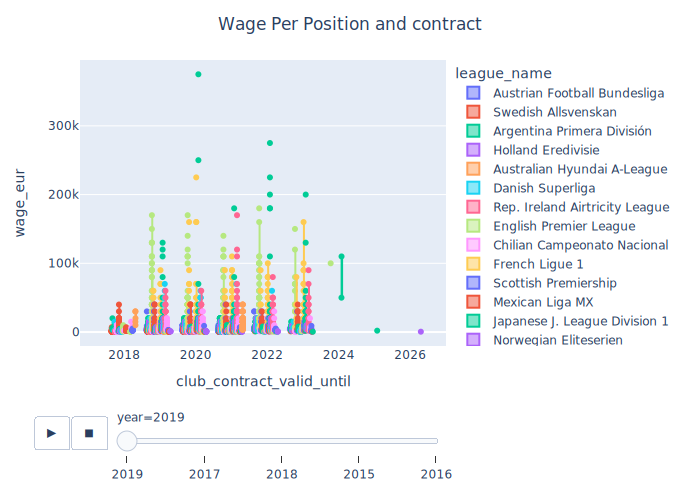

In [48]:
#Bert's visualization

fig = px.box(train, x="club_contract_valid_until", y="wage_eur", points="all", animation_frame='year', color="league_name",
                   hover_name="league_name")
fig.update_xaxes(categoryorder = 'mean ascending')
fig.update_layout(title_text='Wage Per Position and contract ', title_x=0.5)
fig.show(renderer='svg')

In [49]:
#setup crosstab
observed = pd.crosstab(train.seniority, train.wage_eur)

chi2, p, degf, expected = stats.chi2_contingency(observed)
round(p ,3)

#print p-value
print(f'P Value: {p:.3f}')

if p < α:
    print('Reject the null hypothesis.')
else:
    print('Fail to reject the null.')

P Value: 0.000
Reject the null hypothesis.


# Feature Selection

In [50]:
features_cor =  train.corr()['wage_eur'].sort_values(ascending=False)
features_cor = pd.DataFrame(features_cor)
features_cor.head(20)

                                     wage_eur
wage_year                                1.00
wage_eur                                 1.00
total_wage                               0.81
value_eur                                0.81
club_name_yr_sum                         0.73
international_reputation                 0.71
overall                                  0.68
defending                                0.66
standing_tackle                          0.64
sliding_tackle                           0.64
interceptions                            0.61
marking                                  0.60
potential                                0.59
reactions                                0.59
league_yr_sum                            0.52
heading_accuracy                         0.46
short_passing                            0.45
ball_control                             0.43
long_passing                             0.43
aggression                               0.43

#### Select K Best
['short_passing',
 'volleys',
 'curve',
 'long_passing',
 'ball_control',
 'reactions',
 'shot_power',
 'long_shots',
 'vision',
 'potential']

#### RFE
['age',
 'weak_foot',
 'skill_moves',
 'reactions',
 'potential',
 'seniority',
 'preferred_foot_encoded',
 'age_bins_encoded',
 'weight_bins_encoded',
 'body_type_encoded']

## Create X_train, y_train, etc. by Year

#### Establish Baseline

In [51]:
#get baseline, baseline is mean/median of dependent variable yhat_baseline == baseline

baseline = round(train.wage_eur.mean(),2)

print(f' Baseline is: ${baseline}')

 Baseline is: $14011.17


In [52]:
#get baseline, baseline is mean/median of dependent variable yhat_baseline == baseline

baseline = round(train.wage_eur.median(),2)

print(f' Baseline is: ${baseline}')

 Baseline is: $5000.0


In [53]:
features = [
    'potential',
    'reactions',
    'vision',
    'short_passing',
    'long_passing',
    'ball_control',
    'curve',
    'shot_power',
    'volleys',
    'long_shots',
    'fk_accuracy',
    'crossing',
    'skill_dribbling',
    'penalties',
    'positioning',
    'age_bins_encoded',
    'weight_bins_encoded',
    'body_type_encoded',
    'seniority',
    'skill_moves',
    'weak_foot',
    'age',
    'preferred_foot_encoded']

In [54]:
bam.disable()

The bamboolib extension was disabled. You can enable it again via 'bam.enable()'. In case that bamboolib was not helpful to you, we are sorry and would like to fix this. Please write us a quick mail to info@8080labs.com so that we can serve you better in the future. Best regards, Tobias and Florian


In [55]:
train.head()

sofifa_id      short_name player_positions  overall  potential  \
75585     244925  F. Tauchhammer               RB       48         68   
82860     245171    H. Andersson               CB       49         75   
58098     235780         A. Sosa               CB       59         68   
22465     235243      M. de Ligt               CB       63         83   
23266     234925       K. Pierie           CB, LB       65         82   

                 value_eur             wage_eur  age  height_cm  weight_kg  \
75585            50,000.00               500.00   16        183         72   
82860            60,000.00               500.00   16        190         68   
58098           170,000.00             1,000.00   16        177         76   
22465           575,000.00             1,000.00   16        187         77   
23266           950,000.00             1,000.00   16        185         75   

              club_team_id                  club_name  \
75585           111,822.00  RZ Pellets Wolfsberger AC   
82860               705.00                  Örebro SK   
58098           110,404.00     Club Atlético Banfield   
22465               245.00                       Ajax   
23266             1,913.00              SC Heerenveen   

                        league_name  nationality_id nationality_name  \
75585  Austrian Football Bundesliga               4          Austria   
82860           Swedish Allsvenskan              46           Sweden   
58098    Argentina Primera División              52        Argentina   
22465            Holland Eredivisie              34      Netherlands   
23266            Holland Eredivisie              34      Netherlands   

      club_position          position field_position club_joined  \
75585           RES          Reserves       Reserves  2018-07-01   
82860           RES          Reserves       Reserves  2018-01-29   
58098           SUB        Substitute           Subs  2016-07-01   
22465           RES          Reserves       Reserves  2015-09-04   
23266           LCB  Left Centre Back       Defender  2016-07-01   

       club_contract_valid_until         body_type preferred_foot  weak_foot  \
75585                   2,021.00    Lean (170-185)          Right          3   
82860                   2,020.00     Normal (185+)          Right          2   
58098                   2,020.00  Normal (170-185)          Right          3   
22465                   2,018.00     Normal (185+)          Right          4   
23266                   2,018.00       Lean (185+)           Left          3   

       skill_moves  international_reputation      work_rate  pace  shooting  \
75585            2                         1  Medium/Medium    64        25   
82860            2                         1  Medium/Medium    55        26   
58098            2                         1  Medium/Medium    57        34   
22465            2                         1  Medium/Medium    58        28   
23266            2                         1  Medium/Medium    72        25   

       passing  dribbling  defending  physical  crossing  finishing  \
75585       33         45         49        51        46         17   
82860       28         33         49        50        22         24   
58098       38         36         61        60        37         31   
22465       48         40         63        64        27         24   
23266       57         59         64        60        47         20   

       heading_accuracy  short_passing  volleys  skill_dribbling  curve  \
75585                40             29       27               49     29   
82860                44             33       23               28     27   
58098                58             43       34               30     34   
22465                56             67       29               31     28   
23266                60             68       32               55     24   

       fk_accuracy  long_passing  ball_control  acceleration  sprint_speed  \
75

In [56]:
df_filtered = train[train.league_name == "French Ligue 1"]
df_filtered = pd.DataFrame(data=df_filtered)

In [57]:
df_filtered

sofifa_id        short_name player_positions  overall  potential  \
4439     230078       C. Casanova               CB       55         74   
209      229194        A. Georgen               RB       59         75   
2990     243323       E. Valentim               RB       53         69   
1376     212030  A. Rafetraniaina               RB       60         68   
1341     225863       O. Boscagli               CB       64         74   
...         ...               ...              ...      ...        ...   
229        2488         Z. Camara               CB       73         73   
104      146530        Dani Alves               RB       82         82   
1057      52091           P. Evra               LB       80         80   
3678      51620       C. Varrault               CB       70         70   
1490     153260            Hilton               CB       78         78   

                value_eur             wage_eur  age  height_cm  weight_kg  \
4439           150,000.00             2,000.00   16        180         75   
209            275,000.00             2,000.00   16        172         65   
2990           100,000.00             1,000.00   17        180         70   
1376           140,000.00             2,000.00   17        176         65   
1341           500,000.00             2,000.00   17        181         68   
...                   ...                  ...  ...        ...        ...   
229            400,000.00            45,000.00   35        182         76   
104          4,800,000.00            60,000.00   35        172         68   
1057         1,700,000.00            30,000.00   36        174         75   
3678           120,000.00             9,000.00   37        182         76   
1490           700,000.00            20,000.00   39        180         78   

             club_team_id               club_name     league_name  \
4439           110,316.00             GFC Ajaccio  French Ligue 1   
209                 73.00     Paris Saint-Germain  French Ligue 1   
2990               379.00          Stade de Reims  French Ligue 1   
1376                72.00                OGC Nice  French Ligue 1   
1341                72.00                OGC Nice  French Ligue 1   
...                   ...                     ...             ...   
229                 73.00     Paris Saint-Germain  French Ligue 1   
104                 73.00     Paris Saint-Germain  French Ligue 1   
1057               219.00  Olympique de Marseille  French Ligue 1   
3678           110,569.00               Dijon FCO  French Ligue 1   
1490                70.00  Montpellier Hérault SC  French Ligue 1   

      nationality_id nationality_name club_position    position  \
4439              18           France           SUB  Substitute   
209               18           France           RES    Reserves   
2990              18           France           RES    Reserves   
1376             124       Madagascar           RES    Reserves   
1341              18           France           SUB  Substitute   
...              ...              ...           ...         ...   
229               18           France           SUB  Substitute   
104               54           Brazil           SUB  Substitute   
1057              18           France            LB   Left Back   
3678              18           France           SUB  Substitute   
1490              54           Brazil           SUB  Substitute   

     field_position club_joined  club_contract_valid_until         body_type  \
4439           Subs  2015-08-08                   2,016.00  Normal (170-185)   
209        Reserves  2015-07-01                   2,018.00    Lean (170-185)   
2990       Reserves  2018-07-03                   2,021.00  Normal (170-185)   
1376       Reserves  2012-10-01                   2,020.00    Lean (170-185)   
1341           Subs  2015-03-10                   2,016.00    Lean (170-185)   
...             ...         ...                        ...               ...  

In [58]:
messi= train[~train['short_name'].str.contains('messi')]
messi

sofifa_id      short_name player_positions  overall  potential  \
75585     244925  F. Tauchhammer               RB       48         68   
82860     245171    H. Andersson               CB       49         75   
58098     235780         A. Sosa               CB       59         68   
22465     235243      M. de Ligt               CB       63         83   
23266     234925       K. Pierie           CB, LB       65         82   
...          ...             ...              ...      ...        ...   
61586     237744        R. Kawai               CB       55         55   
80396      49511        F. Kippe               CB       66         66   
61269     156480     Y. Nakazawa               CB       67         67   
56980     142818       F. Cubero               CB       73         73   
1490      153260          Hilton               CB       78         78   

                 value_eur             wage_eur  age  height_cm  weight_kg  \
75585            50,000.00               500.00   16        183         72   
82860            60,000.00               500.00   16        190         68   
58098           170,000.00             1,000.00   16        177         76   
22465           575,000.00             1,000.00   16        187         77   
23266           950,000.00             1,000.00   16        185         75   
...                    ...                  ...  ...        ...        ...   
61586             5,000.00               500.00   39        183         75   
80396            45,000.00             2,000.00   39        194         97   
61269            50,000.00             4,000.00   39        187         78   
56980           275,000.00             8,000.00   39        175         72   
1490            700,000.00            20,000.00   39        180         78   

              club_team_id                   club_name  \
75585           111,822.00   RZ Pellets Wolfsberger AC   
82860               705.00                   Örebro SK   
58098           110,404.00      Club Atlético Banfield   
22465               245.00                        Ajax   
23266             1,913.00               SC Heerenveen   
...                    ...                         ...   
61586           112,444.00  Hokkaido Consadole Sapporo   
80396               299.00               Lillestrøm SK   
61269           101,151.00         Yokohama F. Marinos   
56980           101,088.00             Vélez Sarsfield   
1490                 70.00      Montpellier Hérault SC   

                         league_name  nationality_id nationality_name  \
75585   Austrian Football Bundesliga               4          Austria   
82860            Swedish Allsvenskan              46           Sweden   
58098     Argentina Primera División              52        Argentina   
22465             Holland Eredivisie              34      Netherlands   
23266             Holland Eredivisie              34      Netherlands   
...                              ...             ...              ...   
61586  Japanese J. League Division 1             163            Japan   
80396          Norwegian Eliteserien              36           Norway   
61269  Japanese J. League Division 1             163            Japan   
56980     Argentina Primera División              52        Argentina   
1490                  French Ligue 1              54           Brazil   

      club_position           position field_position club_joined  \
75585           RES           Reserves       Reserves  2018-07-01   
82860           RES           Reserves       Reserves  2018-01-29   
58098           SUB         Substitute           Subs  2016-07-01   
22465           RES           Reserves       Reserves  2015-09-04   
23266           LCB   Left Centre Back       Defender  2016-07-01   
...             ...                ...            ...         ...   
61586           RES           Reserves       Reserves  2011-01-01   
80396           RCB  Right Centre Back       Defender  2002-07-03  

In [59]:
# Step: Group by and aggregate
train_nation = train.groupby(['nationality_name']).agg(wage_eur_sum=('wage_eur', 'sum')).reset_index()

# Step: Sort column(s) wage_eur_sum descending (Z-A)
train_nation = train_nation.sort_values(by=['wage_eur_sum'], ascending=[False])


train_nation

nationality_name         wage_eur_sum
123             Spain        24,575,000.00
16             Brazil        24,407,500.00
48             France        18,979,500.00
4           Argentina        17,591,000.00
42            England        15,387,500.00
..                ...                  ...
32               Cuba             2,000.00
95          Nicaragua             1,000.00
102  Papua New Guinea             1,000.00
2             Andorra             1,000.00
124             Sudan               500.00

[145 rows x 2 columns]

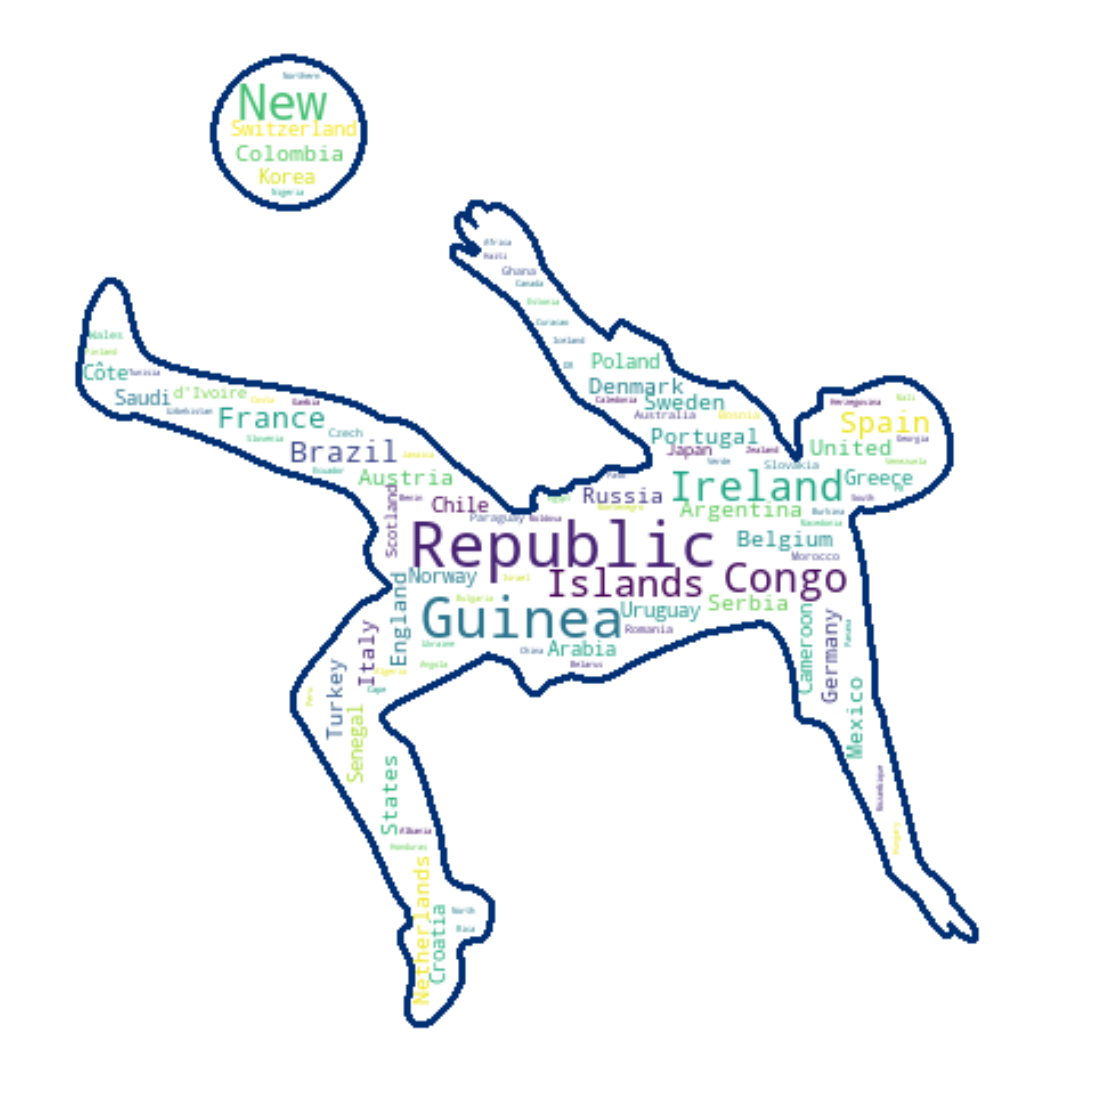

In [60]:
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from PIL import Image
mask = np.array(Image.open("/Users/Ray/Desktop/Screen Shot 2022-08-08 at 14.24.31.png"))
nationality_name = " ".join(n for n in train_nation['nationality_name'])
plt.figure(figsize=[20,20])
wc = WordCloud(width = 3000, height = 2000, random_state=1, background_color="white", max_words=100, 
               mask=mask, contour_color='#023075',contour_width=2).generate(nationality_name) 
ImageColorGenerator(mask, default_color=None)
plt.imshow(wc, interpolation='bilinear') 
plt.axis('off') 
plt.show()

### Most common Nationalities
> - France
> - Germany

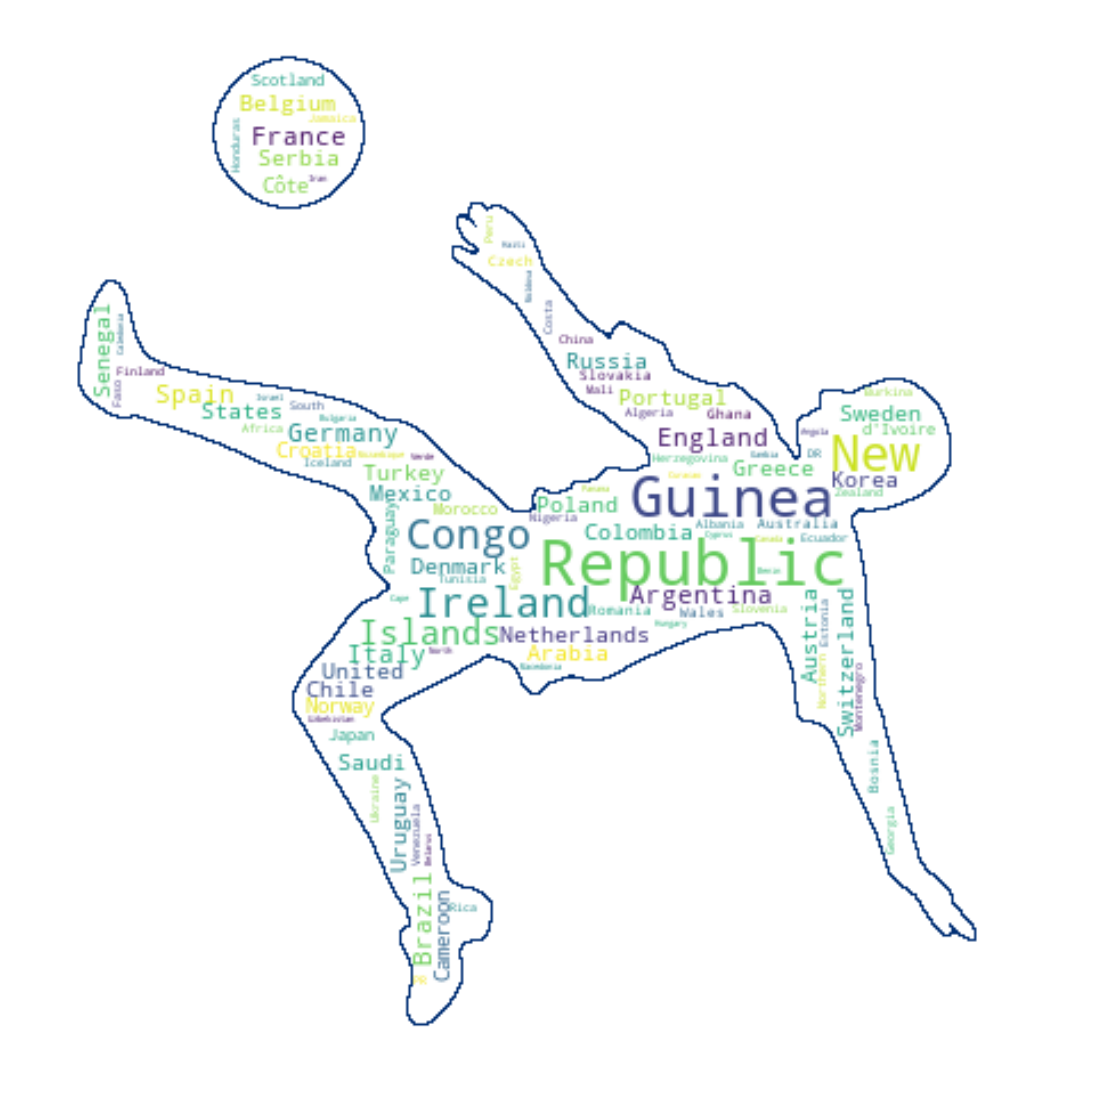

In [61]:
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from PIL import Image
mask = np.array(Image.open("/Users/Ray/Desktop/Screen Shot 2022-08-08 at 14.24.31.png"))
nationality_name = " ".join(n for n in train_nation['nationality_name'])
plt.figure(figsize=[20,20])
wc = WordCloud(width = 3000, height = 2000, background_color="white", max_words=1000, 
               mask=mask, contour_color='#023075',contour_width=1).generate(nationality_name)
#ImageColorGenerator(mask, default_color=None)
plt.imshow(wc, interpolation='bilinear') 
plt.axis('off') 
plt.show()

In [62]:
train_nation.dtypes

nationality_name     object
wage_eur_sum        float64
dtype: object

In [63]:
# Step: Change data type of wage_eur_sum to Integer
train_nation['wage_eur_sum'] = pd.to_numeric(train_nation['wage_eur_sum'], downcast='integer', errors='coerce')


In [64]:
train_nation

nationality_name  wage_eur_sum
123             Spain      24575000
16             Brazil      24407500
48             France      18979500
4           Argentina      17591000
42            England      15387500
..                ...           ...
32               Cuba          2000
95          Nicaragua          1000
102  Papua New Guinea          1000
2             Andorra          1000
124             Sudan           500

[145 rows x 2 columns]

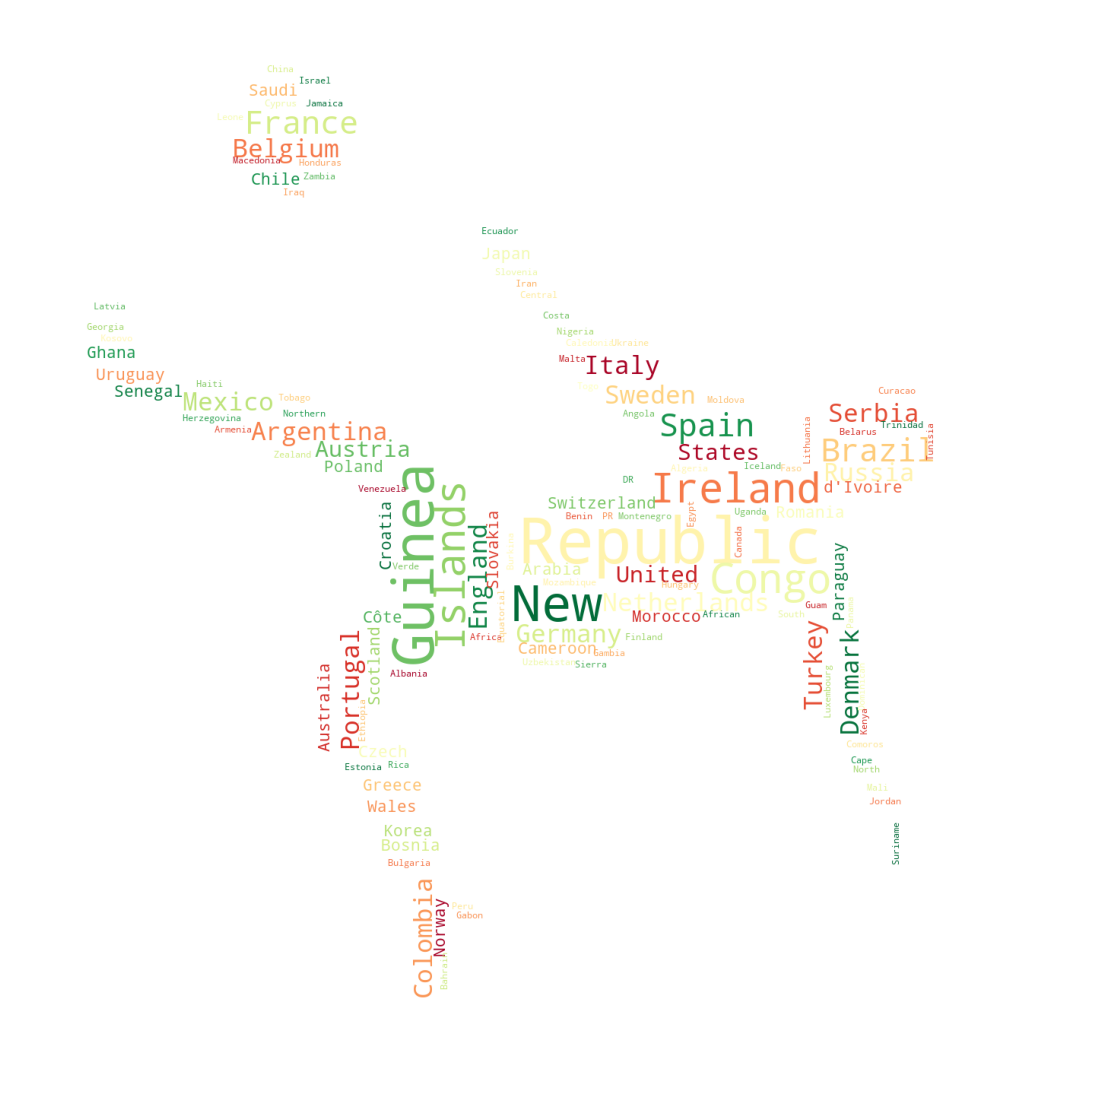

In [65]:
# A similar function, but using the mask
def generate_better_wordcloud(data, mask=None):
    cloud = WordCloud(scale=3,
                      max_words=150,
                      colormap='RdYlGn',
                      mask=mask,
                      background_color='white',
                      collocations=True).generate_from_text(data)
    plt.figure(figsize=(20,20))
    #plt.sort_values(ascending=False)
    plt.imshow(cloud)
    plt.axis('off')
    #plt.title(title)
    plt.show()
    
# Use the function with the nation and our mask to create word cloud     
generate_better_wordcloud(nationality_name,mask=mask)

In [66]:
tuples = [tuple(x) for x in train_nation.nationality_name]

In [67]:
bam.disable()

The bamboolib extension was disabled. You can enable it again via 'bam.enable()'. In case that bamboolib was not helpful to you, we are sorry and would like to fix this. Please write us a quick mail to info@8080labs.com so that we can serve you better in the future. Best regards, Tobias and Florian
